# Set-valued Prediction Based on Utility Maximization 

In [27]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Vector Graphics
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes
from itertools import chain, combinations

import NestedDichotomies.nd as nd

<div align="justify">

Methods for set-valued prediction based on utility maximization (or loss minimization) are primarily used for multi-class classification problems.
Similar to conformal prediction, such methods also return a set of classes when the classifier is too uncertain with respect to the class label to predict, but the interpretation of this set is different. 
Instead of returning a set that contains the true class label with high probability, sets that maximize a set-based utility score are sought.
Besides, being based on the conditional distribution $ \prob(y\,|\,\vec{x}_q) $ of the outcome $ y $ given a query $ \vec{x}_q $, most of these methods capture *conditional* uncertainty. 

Let $u(y,\sety)$ be a set-based utility score, where $y$ denotes the ground truth outcome and $\sety$ the predicted set. Then, adopting a decision-theoretic perspective, the Bayes-optimal solution $\sety^{*}_u$ is found by maximizing the following objective:

$$
\sety^{*}_u(\vec{x}_q) = \argmax_{\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}} \evalue_{p(y\,|\,\vec{x}_q)} \big( u(y,\sety) \big) = \argmax_{\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}} \sum_{y \in \mathcal{Y}} u(y,\sety) \, p(y\,|\,\vec{x}_q) \,.
$$(bayesoptimal)

Solving {eq}`bayesoptimal` as a brute-force search requires checking all subsets of $\mathcal{Y}$, resulting in an exponential time complexity.
Assuming we have four classes as in the figure below, we are interested in predicting the set of the new point $\vec{x}_q =(-0.3,0)$ (light blue in the plot).
We can easily see that there is a large uncertainty aroung this query point as nearly all classes have an example close to this data point.

</div>

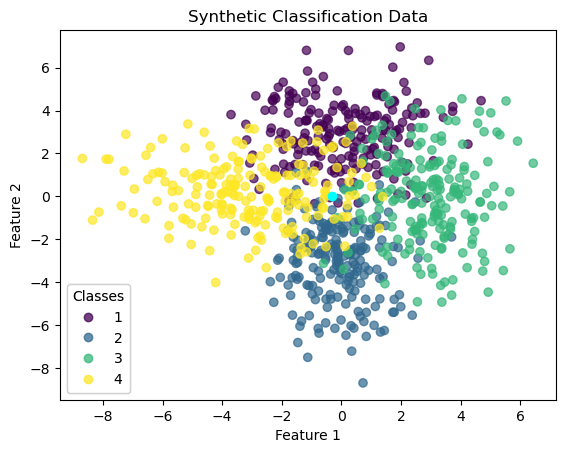

In [28]:

def plot_synthetic_data(ax,X,y, new_point, title):
    ax.set_title(title)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=.7)
    if new_point is not None:
        ax.scatter(*new_point, c="cyan")

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


n_samples = 200
n_classes = 4
classes = np.array(list(range(1,n_classes+1)))
random_state = 41

# parameters for toy data
means = [(0,3),(0,-3),(3,0),(-3,0)]
covs = [np.eye(2)*2.5,np.diag([1.5,2.8]), np.diag([1.5,4.5]), np.diag([3.8,2])]

np.random.seed(random_state)

X = np.vstack([
    np.random.multivariate_normal(mean,cov,n_samples) 
    for mean,cov in zip(means,covs)
])
y = np.hstack([np.full(n_samples,i) for i in classes])

x_q = np.array([-.3, 0])

fig, ax = plt.subplots()

plot_synthetic_data(ax,X,y,x_q,"Synthetic Classification Data")

plt.show()

We firstly must train an classification model on the data, here we choose the [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html), through  whom we get the conditional probability $p(y\,|\,\vec{x}_q)$.

In [29]:
gaussian_model = GaussianNB()
gaussian_model.fit(X,y)
conditional_probability_query_point = gaussian_model.predict_proba(x_q.reshape(1,-1))
for i in classes:
    print(f"P(y = {i} | x_q) = {round(conditional_probability_query_point[0][i-1], 3)}")

P(y = 1 | x_q) = 0.188
P(y = 2 | x_q) = 0.34
P(y = 3 | x_q) = 0.061
P(y = 4 | x_q) = 0.412


In [41]:
conditional_probability_query_point

array([[0.18801898, 0.3396042 , 0.06080846, 0.41156836]])

<div align="justify">

To predict the set $\sety$ we must iterate over all possible $\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}$ to construct the prediction interval. 
We choose as utility score 

$$

u(y,\sety) = \left \{ 
\begin{array}{cl}
0 &\quad \mbox{if $y \notin \sety$} \ \\
\frac{2}{ (1 + |\sety| }&\quad \mbox{if $y \in \sety$} 
\end{array} \, ,
\right.

$$

Intuitively it gives a reward of 0, if the true label is not contained in the prediction set and penalizes bigger sets over smaller ons.
Especially for $|\sety| = 1$ the utility score is maximized, i.e. $u(y,\sety) = 1$ .
A more general formulation of $u(y,\sety)$ will be introduced in {ref}`general_utility_function`.


</div>


In [30]:
def choosen_utility_function(y,set_prediction):    
    if y in set_prediction:
        score = len(set_prediction)
        return 2/(1 + score)
    else:
        return 0

Applying this utility function to the query point $\vec{x}_q$ results in the following prediction set:

In [31]:
def build_possible_prediction_sets(classes):
    "build_possible_prediction_sets([1,2]) → (True,False) (False,True) (True,True)"
    power_set = list(chain.from_iterable(combinations(classes, r) for r in range(1,len(classes)+1)) ) # powerset without the empty set
    
    masked_power_set = np.array([ # build masked sets, where True indicates that the class is contained and False otherwise.
        [i in set for i in classes]
        for set in power_set
    ])
    
    return masked_power_set # we start with 1 to not have the empty set contained

def build_masked_prediction_set(utility_function, classes, conditional_probability):
    """Build the set prediction based on utility_score and conditional_probability.
       For each conditional probability in conditional_probability a set prediction is contstructed.

    Args:
        utility_function (Y x classes -> Float): 
            utility measure which takes the true y label in its first argument.
            The second parameter is the possible prediction set. 
            The type is equal to the classes parameter.
        classes (np.ndarray[int]): Array containing all possible class labels.
        conditional_probability (np.ndarray([[float]])): the conditional probabilities where the dimension are: n_samples x n_classes
        Thus entry (i,j) denotes the conditional probability P( Y= y_(j+1) | X = x_(i)).


    Returns:
        np.ndarray([[bool]]): Returns masked prediction sets with the dimension n_samples x n_classes.
        For each entry (i,j) equal to True this means that for point i the prediction sets contains class (j+1).
        An entry False means that for point i the prediction sets does not contain class (j+1).
    """
    n_samples,n_classes = conditional_probability.shape
    
    #  instead of sets we have boolean values indicating whether the class is contained in the possible prediction set
    masked_prediction_set = build_possible_prediction_sets(classes)
    
    # Save the max_value for all samples, Save the prediction_sets for all samples as True,False Arrays indicating if the class is contained
    max_value,set_prediction = np.zeros(n_samples,dtype=np.float64), np.zeros((n_samples,n_classes),dtype=bool)
    
    # iterate over all possible prediction_sets
    for masked_sets in masked_prediction_set: 
        # build the averaged score the prediction set achieves given the conditional probability
        averaged_utility = np.sum(np.array([utility_function(y,classes[masked_sets]) for y in classes]) * conditional_probability, axis=-1)
        
        # find the max_value and set_prediction. Here update it for all samples in parallel.
        mask = max_value < averaged_utility
        max_value[mask] = averaged_utility[mask]
        
        # update the prediction set
        set_prediction[mask] = masked_sets
            
    return set_prediction


def masked_set_to_prediction_set(masked_set, classes):
    prediction_sets = [
        classes[mask] for mask in masked_set
    ]
    return prediction_sets

def build_prediction_set(utility_function, classes, conditional_probability):
    """Constructs true prediction sets based on utility_function and conditional_probability.
    

    Args:
        utility_function (Y x classes -> Float): 
            utility measure which takes the true y label in its first argument.
            The second parameter is the possible prediction set. 
            The type is equal to the classes parameter.
        classes (np.ndarray[int]): Array containing all possible class labels.
        conditional_probability (np.ndarray([[float]])): the conditional probabilities where the dimension are: n_samples x n_classes.
        Thus entry (i,j) denotes the conditional probability P( Y= y_j | X = x_i)


    Returns:
        [[int]]: Returns a list of all set predictions for each data point represented in  conditional_probability.
    """
    # Firstly we find for all samples the masked_prediction sets. True indicates the class is contained in the predicted set and False otherwise.
    masked_prediction_set = build_masked_prediction_set(utility_function, classes, conditional_probability) 
    
    # Replace the True/False array with the class labels.
    prediction_set = masked_set_to_prediction_set(masked_prediction_set, classes)
    
    return prediction_set

prediction_set = build_prediction_set(choosen_utility_function, classes, conditional_probability_query_point)[0]
print("Prediction set for x_q: ", prediction_set ) # print the prediction set of the first query point

Prediction set for x_q:  [2 4]


(general_utility_function)=
## General utility function

<div align="justify">

However, for many utility scores, the Bayes-optimal prediction can be found more efficiently. Various methods in this direction have been proposed under different names and qualifications of predictions, such as "indeterminate" {cite:t}`zaffalon2002`, ["credal"](set_predictions) {cite:t}`cora_lr08`, "non-deterministic" {cite:t}`delc_ln09`, and "cautious" {cite:t}`Yang2017b`. 
Although the methods typically differ in the exact shape of the utility function $u: \mathcal{Y} \times 2^{\mathcal{Y}}\setminus \{\emptyset\} \longrightarrow [0,1]$, most functions are specific members of the following family:

$$

u(y,\sety) = \left \{ 
\begin{array}{cl}
0 &\quad \mbox{if $y \notin \sety$} \ \\
g(|\sety|)&\quad \mbox{if $y \in \sety$} 
\end{array} \, ,
\right.

$$(ufamily)


where $|\sety|$ denotes the cardinality of the predicted set $\sety$. 

</div>

In [32]:
# Depending on the application the g_function may contain additional parameters controlled by g_params[str, any].
def utility_function(g_function,y,set_prediction, g_params):
    """Construct a utility function used in set-valued prediction.

    Args:
        g (Int -> [Args] -> Int): Function which takes always as first argument a int representing the set size of Y containing the true y.
            Optional parameters [Args] can be given defined by g_params argument.
        y (int): the true class label
        set_prediction (np.ndarray[int]): array with the predicted labels of the model
        g_params ( dict[str,any] ): A dictionary containing the additional parameters of the g_function

    Returns:
        float: The utility of the set_prediction given g and y.
    """
    if y in set_prediction:
        return g_function(len(set_prediction), **g_params)
    else:
        return 0

<div align="justify">

This family is characterized  by a sequence $(g(1), \ldots,g(K)) \in [0,1]^K$ with $K$ the number of classes. 
Ideally, $g$ should obey the following properties: 

1. $g(1) = 1$, i.e., the utility $u(y,\sety)$ should be maximal when the classifier returns the true class label as a singleton set.
2. $g(s)$ should be non-increasing, i.e., the utility $u(y,\sety)$ should be higher if the true class is contained in a smaller set of predicted classes.
3. $g(s) \geq 1/s$, i.e., the utility $u(y,\sety)$ of predicting a set containing the true and $s-1$ additional classes should not be lower than the expected utility of randomly guessing one of these $s$ classes. This requirement formalizes the idea of risk-aversion: in the face of uncertainty, abstaining should be preferred to random guessing {cite:p}`Zaffalon2012EvaluatingCC`. 

</div>


### Precision, Recall, F1 utility functions

<div align="justify">

Many existing set-based utility scores are recovered as special cases of {eq}`ufamily`, including the three classical measures from information retrieval discussed by {cite:t}`delc_ln09`: precision with $g_P(s) = 1/s$, recall with $g_R(s)=1$, and the F1-measure with $g_{F1}(s) = 2/(1+s)$.  
Let us now apply precision, recall and F1 to the query point and look at the $\sety$:

</div>

In [33]:
##### Precision #####
def g_precision(score):
        return 1/score
def precision_utility(y,set_prediction):
    return utility_function(g_precision,y,set_prediction, g_params={})

##### Recall #####
def g_recall(score):
        return 1
def recall_utility(y,set_prediction):
    return utility_function(g_recall,y,set_prediction, g_params={})

##### F1 #####
def g_f1(score):
        return 2/(1+score)
def f1_utility(y,set_prediction):    
    return utility_function(g_f1,y, set_prediction, g_params={})

# [0] is because we access the prediction set of the first (and only) query point
precision_prediction_set = build_prediction_set(precision_utility, classes, conditional_probability_query_point)[0]
recall_prediction_set = build_prediction_set(recall_utility, classes, conditional_probability_query_point)[0]
f1_prediction_set = build_prediction_set(f1_utility, classes, conditional_probability_query_point)[0]

print("Prediction set for x_q with Precision-measure: ", precision_prediction_set)
print("Prediction set for x_q with Recall-measure: ", recall_prediction_set)
print("Prediction set for x_q with F1-measure: ", f1_prediction_set)

Prediction set for x_q with Precision-measure:  [4]
Prediction set for x_q with Recall-measure:  [1 2 3 4]
Prediction set for x_q with F1-measure:  [2 4]


<div align="justify">

We see that precision and recall results in singleton and full set respecitively. Thus they can be seen as two extrema. 
The F1-measure balances this by constructing the set only containing the two classes with high probabilities for x_q (see conditional probabilities above).
Let us now look at the prediction sets for every data point that might be observed in our example:

</div>

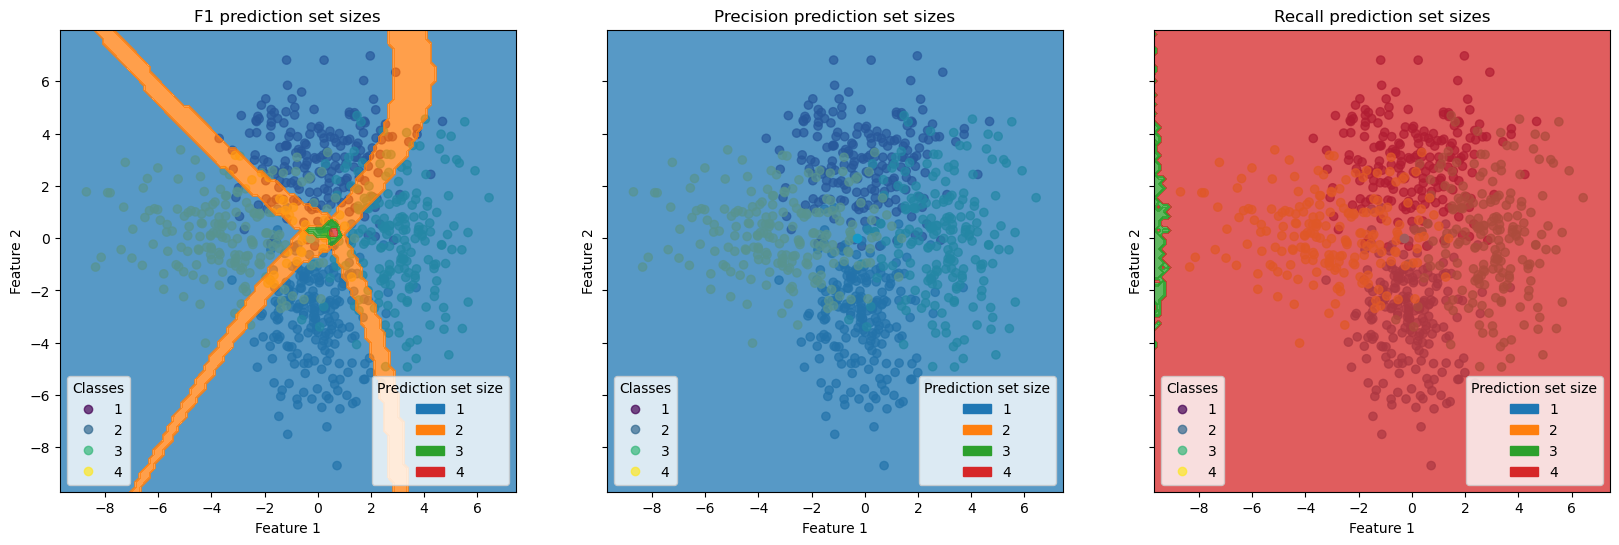

In [34]:
def measure_set_builder(measure, classes, model):
    """Generic set_builder function building the  prediction sets.
    Args:
        measure (Y x classes -> Float): 
            utility measure which takes the true y label in its first argument.
            The second parameter is the possible prediction set. 
            The type is equal to the classes parameter.
        classes (np.ndarray[int]): Array containing all possible class labels.
        model (classifier): Classification model having a .predict_proba(X) giving the conditional probabilities for each class.
    """
    def measure_set_builder(X):
        return build_prediction_set(measure, classes, model.predict_proba(X))
    return measure_set_builder

# Default wrapper we use for the contour function. 
# Specifies both the classes and the model for our example
def default_measure_set_builder(measure):
    return measure_set_builder(measure, classes, gaussian_model)

def plot_setsize_contour(ax, X, y, set_builder, title):
    """Plots a contour plot of the set_sizes induced  by the set_builder.

    Args:
        ax (matplotlib.axes): axes of matplotlib 
        X (np.ndarray): The data points which span the grid for the contour plot.
        y (np.ndarray): The labels of the data points X.
        set_builder (X -> [y]): function taking data points X and predicting class label sets.
        title (str): The title of the contour plot.
    """
     
    # create all the points we will calculate the prediction set sizes
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    x_grid = np.linspace(x_min,x_max, 100)
    y_grid = np.linspace(y_min, y_max, 100)
    
    xv, yv = np.meshgrid(x_grid,y_grid)
    
    points = np.column_stack((xv.ravel(), yv.ravel()))
    
    # calculate set sizes
    set_sizes = list(map(len,set_builder(points)))
    set_sizes = np.array(set_sizes).reshape(y_grid.shape[0], x_grid.shape[0])  
         
    #print("Set sizes: ", np.unique(set_sizes))
            
    # Build the Discrete Color Map
    cmap = mpl.colormaps["tab10"]  # define the colormap

    # define the bins and normalize
    bounds = np.linspace(0,len(classes)+1,len(classes)+1)
    
    norm = mpl.colors.BoundaryNorm(bounds,
                                len(classes))
  
    # plot the data points
    plot_synthetic_data(ax,X,y,x_q,title)

    # create contour plot
    contour = ax.contourf(x_grid, y_grid, set_sizes, alpha=.75, cmap=cmap,norm=norm)


    legend_labels = {
        0:"1",
        1:"2",
        2:"3",
        3:"4"
    }

	# Create legend patches
    patches = [Patch(color=cmap(norm(i+1)), label=label) for i,label in legend_labels.items()]

	# Add the legend with the patches
    legend = ax.legend(handles=patches, loc='lower right',title="Prediction set size",frameon=True)
    
    ax.set_title(title)

          
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,6), sharey=True)

plot_setsize_contour(ax[0],X,y,default_measure_set_builder(f1_utility), "$F_1$ prediction set sizes")
plot_setsize_contour(ax[1],X,y,default_measure_set_builder(precision_utility),"Precision prediction set sizes")
plot_setsize_contour(ax[2],X,y,default_measure_set_builder(recall_utility), "Recall prediction set sizes")
plt.show()

<div align="justify">

Recall does not build any singleton sets whereas precision only predicts singleton sets. 
The $F_1$-measure balances both recall and precision and constructs all possible sets.
The set containing three and four classes are predicted for samples close to the center of the class overlaps.
Thus the prediction sizes increases with increasing uncertainty of the model, i.e. overlapping areas of the data poins.

</div>

### Parametric Utility Functions

<div align="justify">

In the literature on credal classification specific choices of $g$ are studied, which are parametric {cite:p}`Corani2008NCC,Corani2009LNCC,Zaffalon2012EvaluatingCC,Yang2017b,mpub385`:

$$

g_{\delta,\gamma}(s) := \frac{\delta}{s} - \frac{\gamma}{s^2} \,, \quad g_{\exp}(s) := 1- \exp{\left(-\frac{\delta}{s}\right)},   \quad g_{log}(s) := \log \left(1 + \frac{1}{s} \right) \,.

$$



</div>

In [35]:
##### Delta-Gamma #####
def g_delta_gamma(score,delta,gamma):
    return (delta/score) - (gamma/score**2)
def delta_gamma_utility_wrapper(delta, gamma):
    # wrapper function is needed to have the delta/gamma parameter fixed before applying the utility function.
    def delta_gamma_utility(y,set_prediction):
        return utility_function(g_delta_gamma, y, set_prediction, g_params={"delta":delta,"gamma":gamma})
    return delta_gamma_utility

##### Exponential #####
def g_exponential(score, delta):
            return 1 - np.exp(- delta/score)
def exponential_utility_wrapper(delta):
    # wrapper function is needed to have the delta parameter fixed before applying the utility function.
    def exponential_utility(y,set_prediction):
        return utility_function(g_exponential,y,set_prediction, g_params={"delta":delta})
    return exponential_utility

##### Logarithmic #####
def g_logarithmic(score):
        return np.log2(1 + 1/score)
def logarithmic_utility(y, set_prediction):
    return utility_function(g_logarithmic, y , set_prediction ,g_params={})

<div align="justify">

Especially $g_{\delta,\gamma}(s)$ is commonly used in this community, where $\delta$ and $\gamma$ can only take certain values to guarantee that the utility is in the interval $[0,1].$ 
Precision (here called discounted accuracy) corresponds to the case $(\delta,\gamma)=(1,0)$. 
However, typical choices for $(\delta,\gamma)$ are $(1.6,0.6)$ and $(2.2,1.2)$ {cite:p}`mpub385`. 
The measure $g_{\exp}(s)$ is an exponentiated version of precision, where the parameter $\delta$ also defines the degree of risk aversion.

</div>


In [36]:
delta_16_gamma_06 = delta_gamma_utility_wrapper(1.6, 0.6)
delta_22_gamma_12 =  delta_gamma_utility_wrapper(2.2, 1.2)

delta_16_prediction_set = build_prediction_set(delta_16_gamma_06, classes, conditional_probability_query_point)[0]
delta_22_prediction_set = build_prediction_set(delta_22_gamma_12, classes, conditional_probability_query_point)[0]
logarithmic_prediction_set = build_prediction_set(logarithmic_utility, classes, conditional_probability_query_point)[0]

print("Prediction set for x_q with delta=1.6 and gamma=0.6: ", delta_16_prediction_set )
print("Prediction set for x_q with delta=2.2 and gamma=1.2: ", delta_22_prediction_set )
print("Prediction set for x_q with logarithmic function: ", logarithmic_prediction_set )

Prediction set for x_q with delta=1.6 and gamma=0.6:  [2 4]
Prediction set for x_q with delta=2.2 and gamma=1.2:  [2 4]
Prediction set for x_q with logarithmic function:  [2 4]


<div align="justify">

We can see that all three approaches construct the same prediction set for $\vec x_q$.
Yet the differ the region where $\sety$ bigger one in predicted. 
Therefore we again visualize the prediction set sizes for all data points that might be observed in our example:


</div>

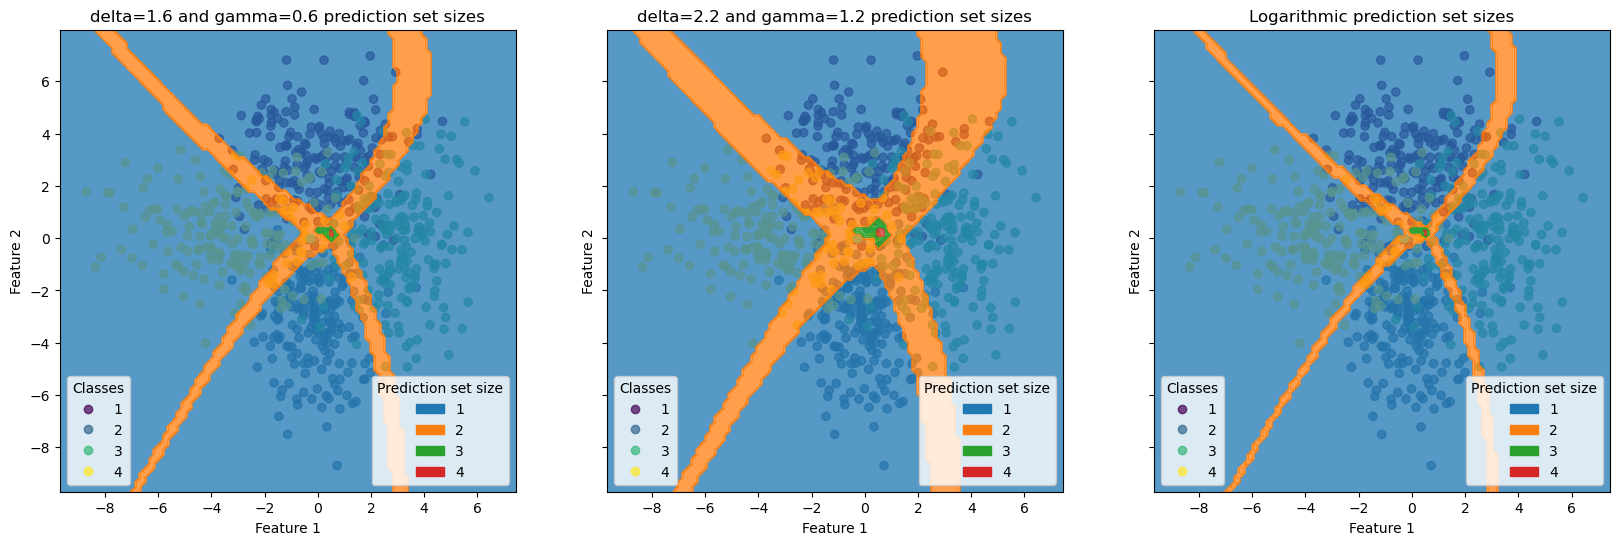

In [37]:
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,6), sharey=True)

plot_setsize_contour(ax[0],
                     X,
                     y,
                     default_measure_set_builder(delta_16_gamma_06),
                     "delta=1.6 and gamma=0.6 prediction set sizes")
plot_setsize_contour(ax[1],
                     X,
                     y,
                     default_measure_set_builder(delta_22_gamma_12),
                     "delta=2.2 and gamma=1.2 prediction set sizes")
plot_setsize_contour(ax[2],
                     X,
                     y,
                     default_measure_set_builder(logarithmic_utility),
                     "Logarithmic prediction set sizes")
plt.show()

<div align="justify">

Known from {cite:t}`mpub385`, $(\delta,\gamma) = (2.2,1.2)$ has a higher risk aversion thus leading to larger areas were set sizes bigger than one are predicted. 
With $(\delta,\gamma) = (1.6,0.6)$ the areas were larger set sizes are predicted shrinks to the overlapping areas of the classes.
The logarithmic score further narrows this corridor.
Notice that for each utility function all four possible set sizes are predicted, yet the areas for $|\sety| = 4$ are very narrow for both $(\delta,\gamma) = (1.6,0.6)$ and logarithmic score function..

</div>

<div align="justify">


Another example appears in the literature on binary or multi-class classification with reject option {cite:p}`herb_cw06,linu_cw18,Ramaswamy2015CAMCRO`. Here, the prediction can only be a singleton or the full set $\mathcal{Y}$ containing $K$ classes. The first case typically gets a reward of one (if the predicted class is correct), while the second case should receive a lower reward, e.g. $1-\alpha$.  The latter corresponds to abstaining, i.e., not predicting any class label, and the (user-defined) parameter $\alpha$ specifies a penalty for doing so, with the requirement $0< \alpha < 1-1/K$ to be risk-averse. 

</div>

In [38]:
##### Abstain #####

def g_abstain(score, alpha_value):
            if score == 1:
                # because of utility_function set_predictions == {y}, i.e. only contains y
                return 1
            elif score == n_classes:
                return 1-alpha_value
            else:
                # Other options will be heavily penalized.
                return -1        
def abstain_utility_wrapper(alpha_value):
    def abstain_utility(y,set_predictions):
        return utility_function(g_abstain,y, set_predictions, g_params={"alpha_value":alpha_value})
    return abstain_utility

risk_averse_values = np.linspace(0,1-1/n_classes,4,endpoint=False)[1:] # only valid risk-averse values 0 < alpha < 1 - 1/K

most_risk_averse_utility = abstain_utility_wrapper(risk_averse_values[0]) # is close to 0 thus will be very risk averse
middle_risk_averse_utility = abstain_utility_wrapper(risk_averse_values[1]) # is inbetween 0 and 1 - 1/K
barly_risk_averse_utility  = abstain_utility_wrapper(risk_averse_values[2]) # is less risk averse as it is close to 1 - 1/K

biggest_prediction_set = build_prediction_set(most_risk_averse_utility,classes,conditional_probability_query_point)[0]
middle_prediction_set = build_prediction_set(middle_risk_averse_utility,classes,conditional_probability_query_point)[0]
smallest_prediction_set = build_prediction_set(barly_risk_averse_utility,classes,conditional_probability_query_point)[0]
print("Prediction set for x_q with biggest risk-aversity: ", biggest_prediction_set)
print("Prediction set for x_q with middle risk-aversity: ", middle_prediction_set)
print("Prediction set for x_q with low rist-aversity: ", smallest_prediction_set)


Prediction set for x_q with biggest risk-aversity:  [1 2 3 4]
Prediction set for x_q with middle risk-aversity:  [1 2 3 4]
Prediction set for x_q with low rist-aversity:  [1 2 3 4]


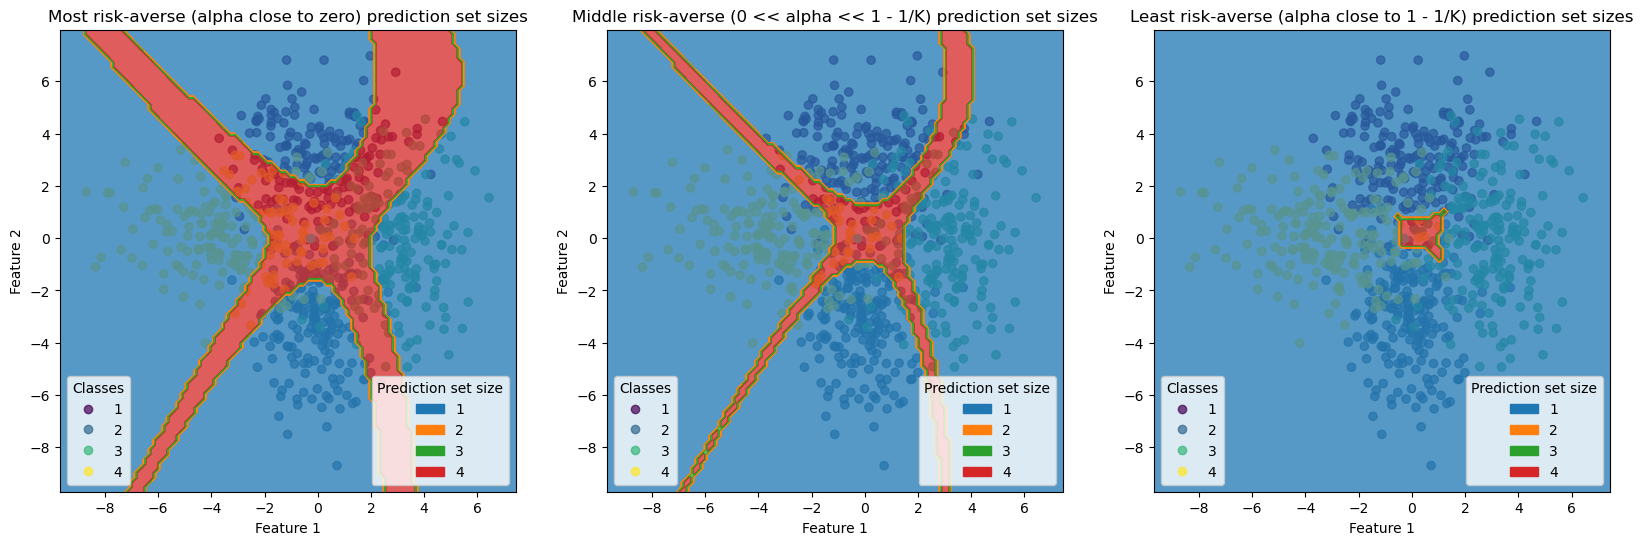

In [39]:
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

plot_setsize_contour(ax[0],X,y,default_measure_set_builder(most_risk_averse_utility), "Most risk-averse (alpha close to zero) prediction set sizes")
plot_setsize_contour(ax[1],X,y,default_measure_set_builder(middle_risk_averse_utility),"Middle risk-averse (0 << alpha << 1 - 1/K) prediction set sizes")
plot_setsize_contour(ax[2],X,y,default_measure_set_builder(barly_risk_averse_utility), "Least risk-averse (alpha close to 1 - 1/K) prediction set sizes")
plt.show()

<div align="justify">

The lower we set our $\alpha$ value the more risk the classifier takes with predicting a single label. Increasing $\alpha$ increases the tendincy to predict the complete set. Setting $\alpha = 0$ would be identical to using recall as utility and $\alpha = 1$ identical to precision (see above figures).

</div>

## Hierarchical multi-class classification

<div align="justify">

Set-valued predictions are also considered in hierarchical multi-class classification, mostly in the form of internal nodes of the hierarchy  {cite:p}`Freitas_atutorial,Rangwala2017,Yang2017`. 
Compared to the ''flat'' multi-class case, the prediction space is thus restricted, because only sets of classes that correspond to nodes of the hierarchy can be returned as a prediction. Some of the above utility scores also appear here. 
For example, {cite:t}`Yang2017` evaluate various members of the $u_{\delta,\gamma}$ family in a framework where hierarchies are considered for computational reasons, while {cite:t}`Oh2017TopKHC` optimizes recall by fixing $|\sety|$ as a user-defined parameter. 

To gain an understanding of hierarchical multi-class classification we will use implementations provided by {cite:p}`DBLP:journals/ml/MelnikovH18`. The idea is to divide the multi-class methods into a forest of nested dichotomy. 
The forest consists of 50 randomly constructed nested dichotomies, where the resulting prediction set is constructed through majority voting {cite:p}`Yang2017`, i.e. a class c is contained in the prediction set if a majority of the nested dichotomies predicted this class with the highest probability.
If no class gets a majority the set containing all classes is returned.

</div>

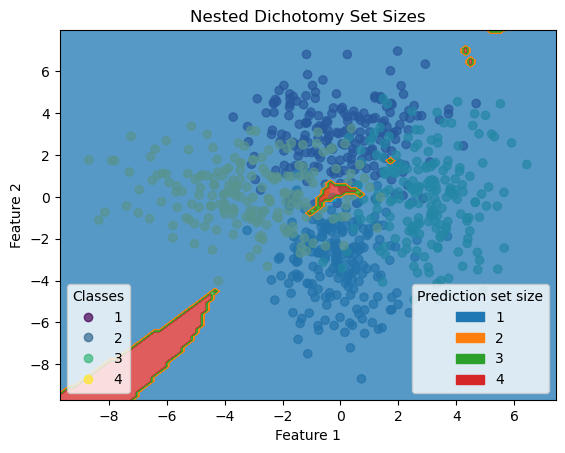

In [40]:

def build_ensemble_random_nd(seed, n_classes,number_nd = 10, model_type= naive_bayes.GaussianNB):
    ensemble = []
    
    random_generator = np.random.default_rng(seed)
    
    for i in range(number_nd):
        nd2d = nd.RandomGeneration.generate(n_classes, seed=random_generator.integers(low=0,high=100)) # make "random" nested dichotomies
        nested_dichotomy = nd.NestedDichotomy.parse(nd2d)

        base_learner = model_type # this can be changed to any probabilitic classifier
        
        nd.NestedDichotomy.train(nested_dichotomy, X, y-1, base_learner) # updates the models of the nested dichotomie inplace
        
        ensemble.append(nested_dichotomy)

    return ensemble

def build_nd_masked_prediction_sets(ensemble, X_test, classes):
    n_classes = len(classes)

    
    prediction_set = np.zeros(shape=(len(X_test),n_classes), dtype=bool)
    for c in classes:
        res = np.array([
            # constructs an array where True indicates that the class c has been predicted by the ensemble for the X_test data points
            c == (np.argmax(nd.NestedDichotomy.predict_proba(nested_dichotomy, X_test, n_classes), axis=-1) + 1) # get the class with highest probability. Minimize the 0/1 loss
            for nested_dichotomy in ensemble
        ]).T
        
        # Check if a majority of dichotomies have predicted this class
        majority_mask = np.sum(res,axis=-1) > len(ensemble) / 2
        
        prediction_set[
            majority_mask,c-1
        ] = True # indicate that the majority of nested_dichotomies have predicted this class
    
    mask_no_majorities = np.sum(prediction_set, axis=-1) == 0
    prediction_set[mask_no_majorities,:] = True
    
    return prediction_set

def build_nd_prediction_sets(ensemble, classes, X):
    maked_predictions = build_nd_masked_prediction_sets(ensemble, X, classes)
    
    prediction_sets = masked_set_to_prediction_set(maked_predictions, classes)
    
    return prediction_sets

def set_builder_nd(ensemble,classes):
    def set_builder_nd(X):
        return build_nd_prediction_sets(ensemble, classes, X)
    return set_builder_nd

ensemble = build_ensemble_random_nd(seed=42,n_classes=4,number_nd=50, model_type=naive_bayes.GaussianNB)

fig, ax = plt.subplots()

plot_setsize_contour(ax,X,y,set_builder_nd(ensemble,classes),"Nested Dichotomy Set Sizes")
plt.show()

<div align="justify">


We can deduce from the contour plot that the predicted set sizes in this example only are the singleton set or all classes. 
The overlapping areas and areas with sparse data leads the hierarchical classifier to predict the complete set. 
In all other regions with plenty of samples the classifier intuitively only predicts the singleton set.


</div>

<div align="justify">

A different approach in hierarchical classification is the tree-distance loss, which could also be interpreted as a way of evaluating set-valued predictions {cite:p}`Bi2015`. 
This loss is not a member of the family ({eq}`ufamily`), however. 
Besides, it appears to be a less interesting loss function from the perspective of abstention in cases of uncertainty, since by minimizing the tree distance loss, the classifier will almost never predict leaf nodes of the hierarchy. 
Instead, it will often predict nodes close to the root of the hierarchy, which correspond to sets with many elements\,---\,a behavior that is unfavored if one wants to abstain only in cases of sufficient uncertainty. 


</div>


## Uncertainty quantification

<div align="justify">


Quite obviously, methods that maximize set-based utility scores are closely connected to the quantification of uncertainty, since the decision about a suitable set of predictions is necessarily derived from information of that kind. The overwhelming majority of the above-mentioned methods depart from conditional class probabilities $p(y \given \vec{x}_q)$ that are estimated in a classical frequentist way, so that uncertainties in decisions are of aleatoric nature. 
Exceptions include {cite:p}`Yang2017` and {cite:p}`mpub385`, who further explore ideas from imprecise probability theory and reliable classification to generate label sets that capture both aleatoric and epistemic uncertainty.   

</div>
